In [1]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.visualization import hist
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np
import sys
from astropy import units as u


sys.path.append("/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline")
import fpnfix
from aperturePhot import showimage as show_image

In [2]:
path = "/home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/"
day = "20201117"
path_day = os.path.join(path, day)

data_red = Path(path_day, "Reduced_Images")
data_red.mkdir(exist_ok = True)

In [3]:
files = ccdp.ImageFileCollection(path_day)
files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

file,imagetyp,filter,exptime,naxis1,naxis2
str24,str11,object,float64,int64,int64
BL_Lac-001B.fit,Light Frame,Bessel B,60.0,1024,1024
BL_Lac-001R.fit,Light Frame,Bessel R,60.0,1024,1024
BL_Lac-001V.fit,Light Frame,Bessel V,60.0,1024,1024
BL_Lacertae-001B.fit,Light Frame,Bessel B,60.0,1024,1024
BL_Lacertae-001V.fit,Light Frame,Bessel V,60.0,1024,1024
BL_Lacertae-002B.fit,Light Frame,Bessel B,60.0,1024,1024
BL_Lacertae-003B.fit,Light Frame,Bessel B,60.0,1024,1024
BL_Lacertae-003R.fit,Light Frame,Bessel R,60.0,1024,1024
BL_Lacertae-003V.fit,Light Frame,Bessel V,60.0,1024,1024


In [4]:
calibrated_biases = files.files_filtered(imagetyp='Bias Frame', include_path=True)

combined_bias = ccdp.combine(calibrated_biases,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu")

combined_bias.meta['combined'] = True

combined_bias.write(os.path.join(data_red / 'combined_bias.fit'), overwrite = True)

In [5]:
calibrated_darks = files.files_filtered(imagetyp='Dark Frame', include_path=True)
reduced_darks= []
exptime= []

for frame in calibrated_darks:
    image = ccdp.CCDData.read(frame, unit = 'adu')
    exptime.append(image.header["exposure"])
    reduced_darks.append(ccdp.subtract_bias(image, combined_bias))
    
combined_darks = ccdp.combine(reduced_darks,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu", scale =1 / np.array(exptime))

combined_darks.header["exposure"] = 1
combined_darks.header['exptime'] = 1

combined_darks.meta['combined'] = True

combined_darks.write(os.path.join(data_red / 'combined_darks.fit'), overwrite = True)

In [6]:
flat_imagetyp = 'Flat Field'

flat_filters = set(h['filter'] for h in files.headers(imagetyp=flat_imagetyp))
flat_filters

{'Bessel B', 'Bessel R', 'Bessel V'}

In [7]:
scale = lambda a: 1/np.median(a)

master_flats = {}

for filt in flat_filters:
    reduced_flats = []
    calibrated_flats = files.files_filtered(imagetyp = flat_imagetyp, filter = filt, include_path=True)
    
    for flat in calibrated_flats:
        image = ccdp.CCDData.read(flat, unit = "adu")
        image = ccdp.subtract_bias(image, combined_bias)
        image = ccdp.subtract_dark(image, combined_darks, scale=True, exposure_unit=u.s, exposure_time = "exptime")
        #image = fpnfix.subtract_fpn(image,combfpn[60],mesh_size=32, verbose = 2)
        reduced_flats.append(image)
    
    combined_flats = ccdp.combine(reduced_flats,
                                 method='median',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, unit = "adu", scale = scale
                                )

    master_flats[filt]=combined_flats.copy()

    combined_flats.write(data_red / (filt.replace("","_")+"_combined_flats.fit"), overwrite = True)

789.7453966140747 1.4826
783.5 799.7434215884891


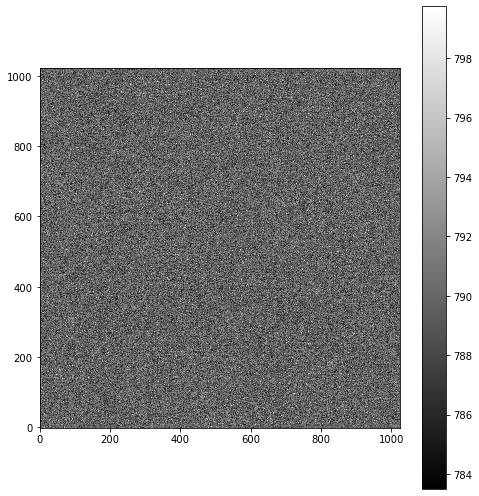

In [8]:
show_image(combined_bias)

0.3292612473169961 0.06177499999999998
0.10833333333333334 0.6631192471391151


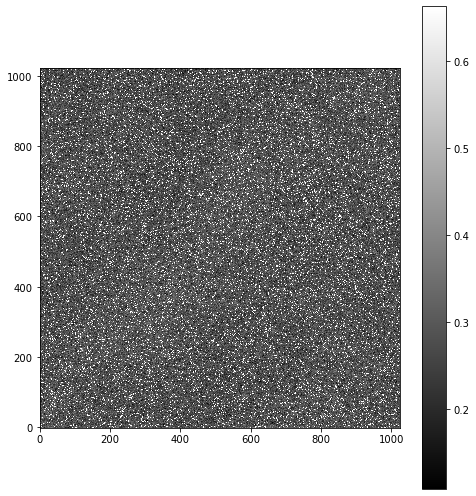

In [9]:
show_image(combined_darks)

1.0021053902119452 0.010647312105721013
0.9609710013226204 1.0411238814028558


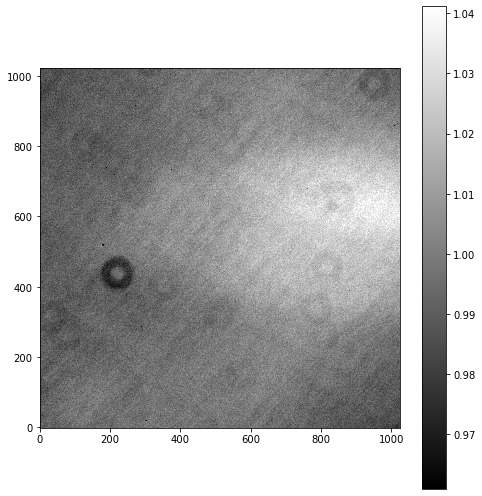

1.0021981300005123 0.013481977325356128
0.9619062629343096 1.0544024360143536


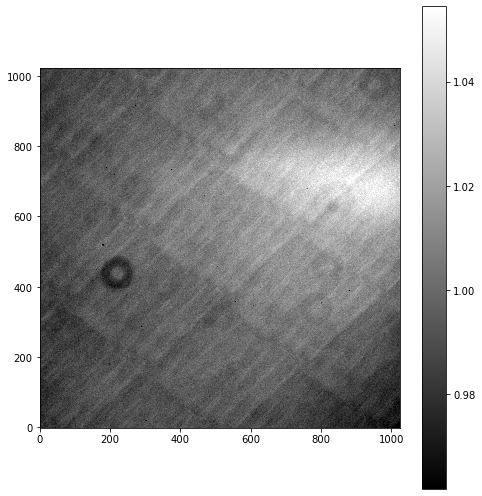

1.0002116965636167 0.009951521176912637
0.9668774077009568 1.0252889241147956


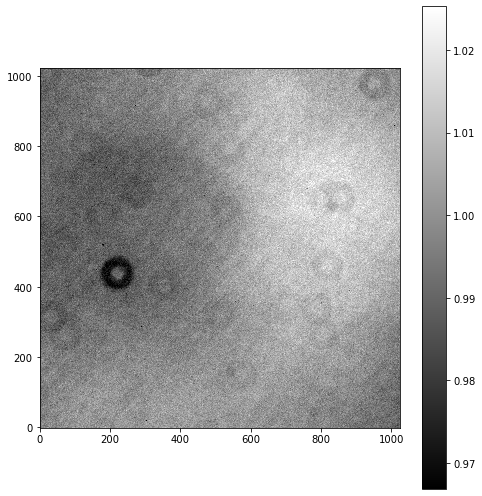

In [10]:
for filt,image in master_flats.items():
    show_image(image)

In [11]:
import ccdproc
images = files.files_filtered(imagetyp="Light Frame", include_path = True)

for image in images:
    var = ccdp.CCDData.read(image, unit = "adu")
    var_filt = var.header["filter"]
    
    corr_filt = master_flats[var_filt]
    
    var = ccdproc.ccd_process(var,
                             master_bias = combined_bias, dark_frame = combined_darks,
                             master_flat = corr_filt, exposure_key="exposure", exposure_unit = u.second,
                             dark_scale = True)
    proc_data = os.path.basename(image)
    var.write(data_red / ("BDF_"+proc_data), overwrite = True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
352.3837969393485 14.425652539519522
306.3199702387612 437.66671484472215


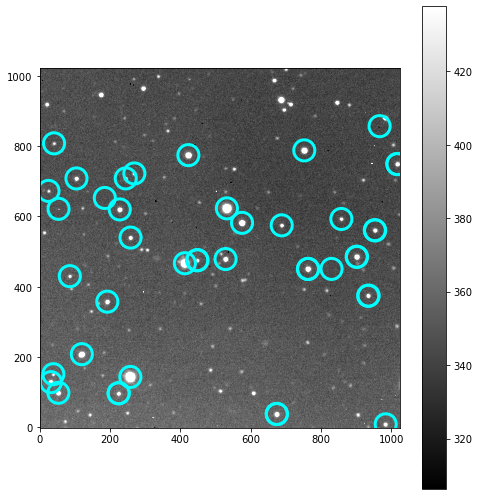

      xcentroid   ycentroid       mag
7    257.371517  143.525349 -4.974164
31   532.138557  623.156424 -4.579307
17   412.523879  467.078836 -4.308030
39   422.530808  774.603134 -2.961268
40   752.271828  788.109574 -2.476790
9    119.292814  208.263772 -2.468465
27   575.178644  581.976384 -2.409147
14   763.392909  450.941154 -1.631429
6     31.392411  128.621181 -1.625182
29   227.227074  620.045067 -1.577384
20   528.294843  478.973503 -1.350437
30    53.166969  621.795293 -1.341289
10   191.848892  357.694822 -1.308651
21   902.148315  485.173489 -1.294028
4     52.668828   98.388784 -1.237299
34   104.088161  708.241817 -1.232688
16   762.768681  450.590892 -1.098131
23   257.935336  539.960699 -0.889828
22   901.371015  485.503595 -0.858038
37  1017.398752  748.839965 -0.791044
1    674.594971   37.874584 -0.787845
24   953.809720  560.297851 -0.660476
36   268.860026  722.479947 -0.571522
3    224.283249   97.165898 -0.570546
35   244.322602  708.319481 -0.527263
13    85.263

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Return code: 0 


dxfit [4.00566993e+02 1.60005868e+00 2.76537763e-01]
dyfit [ 5.24131746e+02 -2.77065255e-01  1.59981220e+00]

scalex, scaley: 0.6158470417824838 0.6159050564204333
anglex, angley: -9.805550720807057 -9.825374669584123
fracdiffs: 0.0020217068211171754 9.420299849374175e-05

# Created by grmatch 0.9e0 (fi: 0.9.4)
# Invoked command: /home/idies/workspace/Storage/madisonleblanc/persistent/bin/grmatch -r /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201117/Reduced_Images/BDF_HH_And_0000_001R.gaia.proj -i /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201117/Reduced_Images/BDF_HH_And_0000_001R.stars.csv -o /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201117/Reduced_Images/BDF_HH_And_0000_001R.match.csv --match-points --col-ref 4,5 --col-inp 2,3 --output-transformation /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201117/Reduced_Images/BDF_HH_And_00

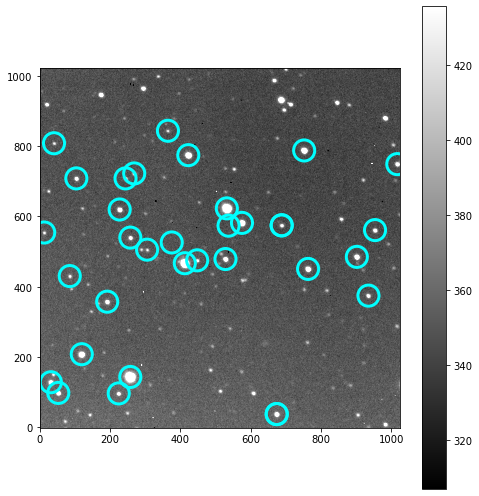

      xcentroid   ycentroid       mag
5    257.231369  143.483819 -4.891600
25   531.944447  623.113166 -4.564987
11   412.314268  467.026155 -4.270208
30   422.288667  774.523543 -2.854951
31   751.921490  787.864706 -2.470544
6    119.140742  208.206716 -2.444285
23   574.973985  581.881187 -2.339280
24   227.004137  619.915699 -1.624736
4     31.236075  128.457272 -1.615468
10   763.073452  450.880540 -1.517354
14   901.782446  485.125919 -1.295650
13   528.089155  478.947815 -1.216970
7    191.527080  357.638005 -1.151630
3     52.410804   98.072820 -1.131716
26   103.732113  708.361521 -1.023889
17   257.359691  539.914628 -0.985565
2    224.319910   96.654556 -0.657629
29  1016.934264  749.018397 -0.654560
0    673.986637   37.705458 -0.645952
1    673.593270   38.024968 -0.609836
28   268.466724  722.516628 -0.408101
19   953.575290  561.295478 -0.377212
8    934.874138  374.813894 -0.355913
32    40.240458  808.408319 -0.349518
22   688.073883  575.212935 -0.337871
12   447.574

In [13]:
import plateSolve
pathlist = Path(data_red).glob('BDF_HH_And*R.fit')

for path in pathlist:
    #show_image(Rimage)
    Rimage = ccdp.CCDData.read(path, unit="adu")
    
    check = plateSolve.autoSolve(path,Rimage, verbose = 1)
    if (check == True):
        #print(check)
        print(Rimage.header['JD-HELIO'])
        print("______________________________________________")
        
    else:
        print("!!!!!!!Plate solve did not work for", path)
        print("______________________________________________")
        print(" ")

In [ ]:
plateSolve.manualSolvePlot(V,Vimage)

In [ ]:
gaia_list = [0,1, 3, 9, 12,17,22,24,54]
image_list = [0,1,4,5,8, 11, 13, 15,16]

check = plateSolve.manualSolve(V,Vimage,gaia_list,image_list)
print("Check is True if successful")
print(V,check)